<a href="https://colab.research.google.com/github/pedrojosefernandez1/RL_FCPSSL/blob/main/MetodosAproximados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio del Comportamiento de Algoritmos de Aprendizaje por Refuerzo por Métodos Aproximado

````
Author: Jaime Pujante Sáez
Email: jaime.pujantes@um.es

Author: Ricardo Javier Sendra Lázaro
Email: ricardojavier.sendral@um.es

Author: Pedro José Fernandez Campillo
Email: pedrojose.fernandez1@um.es
````

En este notebook, se analizará el comportamiento de distintos algoritmos de aprendizaje por refuerzo basados en métodos aproximados, tales como:
- **SARSA semi-gradiente**

El objetivo es evaluar su desempeño en un entorno del framework **Gymnasium**.
## Preparación del entorno
### 1. Clonación del repositorio e instalación de dependencias
Para comenzar, clonamos el repositorio con la implementación de los algoritmos y luego instalamos las dependencias necesarias:


In [1]:
import os
from urllib.parse import urlparse

GITHUB_REPO_URL = "https://github.com/pedrojosefernandez1/RL_FCPSSL.git"
# Extraer usuario y nombre del repositorio automáticamente
def obtener_usuario_y_repo(url):
    path = urlparse(url).path.strip('/')
    parts = path.split('/')
    if len(parts) >= 2:
        return parts[0], parts[1]
    return None, None

GITHUB_USERNAME, GITHUB_REPO_NAME = obtener_usuario_y_repo(GITHUB_REPO_URL)
GITHUB_REPO_NAME = GITHUB_REPO_NAME.replace('.git', '')
if not GITHUB_USERNAME or not GITHUB_REPO_NAME:
    raise ValueError("URL del repositorio inválida. Asegúrate de que sea de GitHub y tenga el formato correcto.")

REPO_NAME = GITHUB_REPO_NAME  # Nombre de la carpeta después de clonar

# Clonar el repositorio si no existe
os.makedirs(REPO_NAME, exist_ok=True)
if not os.path.exists(os.path.join(REPO_NAME, ".git")):
    ! git clone {GITHUB_REPO_URL} {REPO_NAME}

# Verificar si existe un archivo requirements.txt para instalar dependencias
req_file = os.path.join(REPO_NAME, "requirements.txt")
if os.path.exists(req_file):
    ! pip install -r {req_file}

### 2. Importación de librerías necesarias
Una vez instaladas las dependencias, importamos las librerías requeridas para el análisis:

In [2]:
import numpy as np
import gymnasium as gym
import os
import sys

SEED = 32

np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

os.environ['PYTHONHASHSEED'] = str(SEED)

try:
  sys.path.append(f'src')
  print(sys.path)
  from plotting import plot_episode_rewards_subplot, plot_len_episodes_subplot
  from agents.approximation_methods.tile import TileCodingFeatureExtractor
  from agents.approximation_methods.sarsa.sarsa_semi_gradient_epsilongreedy import SarsaSemiGradientEpsilonGreedyAgent  
except:
  sys.path.append(f'{REPO_NAME}/src')
  print(sys.path)
  from plotting import plot_episode_rewards_subplot, plot_len_episodes_subplot
  from agents.approximation_methods.tile import TileCodingFeatureExtractor
  from agents.approximation_methods.sarsa.sarsa_semi_gradient_epsilongreedy import SarsaSemiGradientEpsilonGreedyAgent


['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv', '', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv\\Lib\\site-packages', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\Pythonwin', 'src']


In [3]:
N_EPISODES = 5000

env_cartpole = gym.make("CartPole-v1", render_mode="rgb_array")

low_cartpole = env_cartpole.observation_space.low.copy()
high_cartpole = env_cartpole.observation_space.high.copy()
# Ajustar límites para las dimensiones con valores infinitos:
# Por ejemplo, para la velocidad del carro y la velocidad angular se pueden usar [-3, 3]
low_cartpole[1] = -3.0
low_cartpole[3] = -3.0
high_cartpole[1] = 3.0
high_cartpole[3] = 3.0

env_mountaincar = gym.make('MountainCar-v0', 
                    render_mode="rgb_array", max_episode_steps=500)
low_mountaincar = env_mountaincar.observation_space.low.copy()
high_mountaincar = env_mountaincar.observation_space.high.copy()

In [4]:
# Definir los valores de epsilon, alpha y gamma
epsilon_values = [0.3, 0.7]  # Menos explorador y más explorador
alpha_values = [0.05, 0.01]  # Menos agresivo y más agresivo
gamma_values = [0.999] # Alta valoración futura


# Definir los entornos y sus nombres
environments = {
    "CartPole": env_cartpole,
    "MountainCar": env_mountaincar
}

feature_extractors = {
    "CartPole": TileCodingFeatureExtractor(num_tilings=8, low=low_cartpole, high=high_cartpole, iht_size=2048),
    "MountainCar": TileCodingFeatureExtractor(num_tilings=8, low=low_mountaincar, high=high_mountaincar, iht_size=2048)
}


agents_info = []

for env_name, env in environments.items():
    for epsilon in epsilon_values:
        for alpha in alpha_values:
            for gamma in gamma_values:
                agent = SarsaSemiGradientEpsilonGreedyAgent(env, epsilon=epsilon, gamma=gamma, alpha=alpha, epsilon_decay=0.9995, alpha_decay=0.995, min_epsilon=0, min_alpha=0, feature_extractor=feature_extractors[env_name], seed=SEED)   
                agents_info.append({
                    "agent": agent,
                    "environment": env_name,
                    "epsilon": epsilon,
                    "alpha": alpha,
                    "gamma": gamma
                })

stats_list = []

for info in agents_info:
    agent = info["agent"]
    print (info["environment"])

    agent.train(N_EPISODES, render_interval=500, video_path='videos')
    # Guardar estadísticas con el metadata asociado
    stats_list.append({
        "environment": info["environment"],
        "epsilon": info["epsilon"],
        "alpha": info["alpha"],
        "gamma": info["gamma"],
        "stats": agent.stats()
    })
del agents_info

CartPole


c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\videos\CartPole-v1\SarsaSemiGradientEpsilonGreedyAgent(gamma0.999_alpha0.05_alpha_decay0.995_min_alpha0_epsilon0.3_epsilon_decay0.9995_min_epsilon0) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 5000/5000 [02:15<00:00, 36.81it/s]
c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\videos\CartPole-v1\SarsaSemiGradientEpsilonGreedyAgent(gamma0.999_alpha0.01_alpha_decay0.995_min_alpha0_epsilon0.3_epsilon_decay0.9995_min_epsilon0) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


CartPole


100%|██████████| 5000/5000 [00:13<00:00, 372.74it/s]
c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\videos\CartPole-v1\SarsaSemiGradientEpsilonGreedyAgent(gamma0.999_alpha0.05_alpha_decay0.995_min_alpha0_epsilon0.7_epsilon_decay0.9995_min_epsilon0) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


CartPole


100%|██████████| 5000/5000 [01:38<00:00, 50.56it/s] 
c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\videos\CartPole-v1\SarsaSemiGradientEpsilonGreedyAgent(gamma0.999_alpha0.01_alpha_decay0.995_min_alpha0_epsilon0.7_epsilon_decay0.9995_min_epsilon0) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


CartPole


100%|██████████| 5000/5000 [01:04<00:00, 77.05it/s] 
c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\videos\MountainCar-v0\SarsaSemiGradientEpsilonGreedyAgent(gamma0.999_alpha0.05_alpha_decay0.995_min_alpha0_epsilon0.3_epsilon_decay0.9995_min_epsilon0) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MountainCar


100%|██████████| 5000/5000 [00:54<00:00, 91.65it/s] 
c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\videos\MountainCar-v0\SarsaSemiGradientEpsilonGreedyAgent(gamma0.999_alpha0.01_alpha_decay0.995_min_alpha0_epsilon0.3_epsilon_decay0.9995_min_epsilon0) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MountainCar


100%|██████████| 5000/5000 [01:12<00:00, 68.53it/s]
c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Pedro\Desktop\EXML\RL_FCPSSL\videos\MountainCar-v0\SarsaSemiGradientEpsilonGreedyAgent(gamma0.999_alpha0.05_alpha_decay0.995_min_alpha0_epsilon0.7_epsilon_decay0.9995_min_epsilon0) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MountainCar


  8%|▊         | 425/5000 [00:12<02:16, 33.42it/s]


KeyboardInterrupt: 

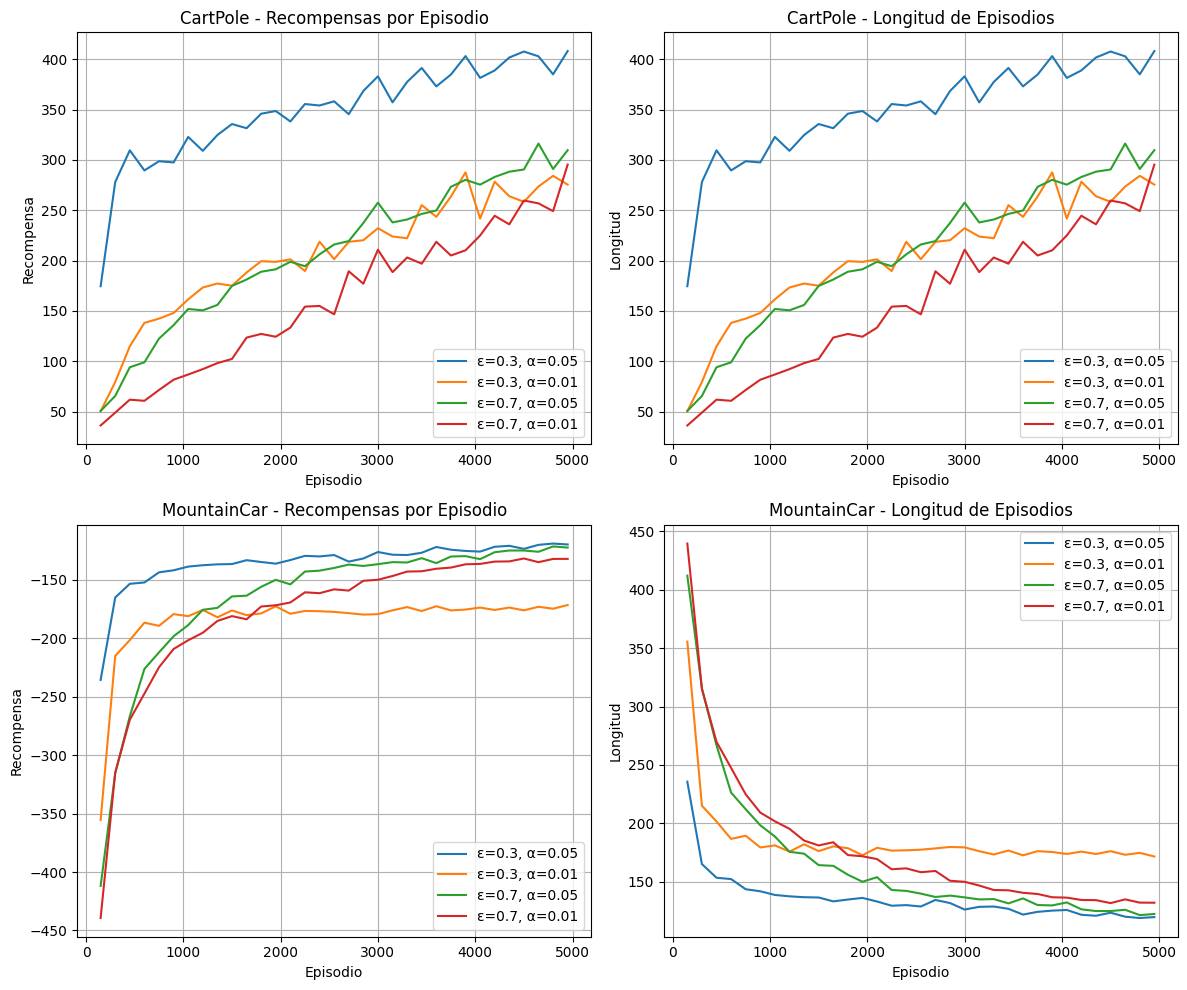

In [ ]:
import matplotlib.pyplot as plt

n_media=150

# Agrupar estadísticas por environment
env_stats = {}
for entry in stats_list:
    env_name = entry["environment"]
    if env_name not in env_stats:
        env_stats[env_name] = []
    env_stats[env_name].append(entry)  # Guardamos todas las configuraciones de epsilon/alpha

# Crear subplots dinámicos según el número de entornos
num_envs = len(env_stats)
fig, axes = plt.subplots(num_envs, 2, figsize=(12, 5 * num_envs))  # (filas, columnas)

# Si solo hay un entorno, convertir `axes` en una lista para evitar errores de indexación
if num_envs == 1:
    axes = [axes]

# Generar gráficos por cada entorno
for idx, (env_name, env_entries) in enumerate(env_stats.items()):
    ax1, ax2 = axes[idx]  # Obtener los ejes de la fila correspondiente

    # Primera columna: Recompensas por episodio
    plt.sca(ax1)  # Establecer el eje activo en ax1
    for entry in env_entries:
        plot_episode_rewards_subplot(entry["stats"]["episode_rewards"], n_media=n_media, ax=ax1)  # Usar tu función
    ax1.set_title(f"{env_name} - Recompensas por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.legend([f"ε={e['epsilon']}, α={e['alpha']}" for e in env_entries])  # Leyenda con α y ε

    # Segunda columna: Longitud de episodios
    plt.sca(ax2)  # Establecer el eje activo en ax2
    for entry in env_entries:
        plot_len_episodes_subplot(entry["stats"]["episodes"], n_media=n_media, ax=ax2)  # Usar tu función
    ax2.set_title(f"{env_name} - Longitud de Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Longitud")
    ax2.legend([f"ε={e['epsilon']}, α={e['alpha']}" for e in env_entries])  # Leyenda con α y ε

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()


## Análisis de los Resultados con Sarsa Semi-gradient en CartPole y MountainCar

Este experimento evalúa un agente que utiliza **Sarsa Semi-gradient** con distintas configuraciones de **ε (epsilon)** y **α (alpha)** en los entornos **CartPole** y **MountainCar** de Gymnasium. Estos parámetros controlan cuánto explora el agente antes de tomar decisiones basadas en lo que ya ha aprendido y en qué proporción expande las recompensas obtenidas en las tablas de pesos respectivamente. Además, tenemos un parámetro adicional gamma (γ), que nos indica la importancia que le daremos de las recompensas futuras frente a las inmediatas. Este parámetro lo fijamos en el experimento a uno que encontramos óptimo para el estudio. El agente sigue una política epsilon-greedy y actualiza sus estimaciones de valor gradualmente en cada paso.

---

### Entorno CartPole

En **CartPole**, la tarea consiste en mantener la barra en equilibrio el mayor tiempo posible. Cada episodio termina cuando la barra cae o se alcanza la longitud máxima establecida.

#### Recompensas por episodio
- Se observa que, con **ε=0.3 y α=0.05**, el agente aprende más rápido y alcanza recompensas cercanas al valor máximo (cerca de 500) al final del experimento.  
- Al disminuir la tasa de aprendizaje (**α=0.01**) pero mantener **ε=0.3**, el agente no converge a recompensas apreciables al unir una exploración baja con un aprendizaje que no acumula las recompensas que encuentre lo suficiente.  
- Con un **ε=0.7**, el agente explora más de la cuenta al inicio, lo que se traduce en una curva de aprendizaje más lenta y recompensas finales menores. Esto se acentúa si además se usa un α más bajo (**α=0.01**), donde las mejoras son aún más graduales debido a la mayor aleatoriedad de las selecciones y tardan más en manifestarse.

#### Longitud de episodios  
- En este problema, una mayor longitud de episodio indica que el agente logra mantener el equilibrio por más tiempo.  
- Nuevamente, la combinación **ε=0.3 y α=0.05** es la más efectiva, pues alcanza la longitud máxima de forma rápida y estable.  
- Con **ε=0.3 y α=0.01**, como hemos dicho anteriormente, el agente no llega a buenos resultados y probablemente debido al decaimiento de ε y α ya no llegue a recuperarse.  
- Valores de **ε=0.7** provocan que el agente pruebe con más frecuencia acciones subóptimas, prolongando el proceso de aprendizaje y manteniendo la longitud de los episodios por debajo de la máxima durante más tiempo. En el caso de **α=0.01** podemos ver cómo aunque el mayor ε afecte mostrando una leve inclinación al final del experimento (indicando que la tendencia sigue siendo hacia soluciones mejores al seguir teniendo un componente de exploración más alto) el bajo α hace que no se aprenda lo suficiente, por lo que no convergerá hacia una solución mucho mejor que la que tiene al final.

---

### Entorno MountainCar

En **MountainCar**, el objetivo es que el coche gane impulso suficiente para escalar la colina en el menor número de pasos posible. Por ello, **recompensas más altas** (menos negativas) y **episodios más cortos** indican un mejor rendimiento.

#### Recompensas por episodio
- Con **ε=0.3 y α=0.05**, el agente mejora rápidamente sus estimaciones y consigue subir la colina con mayor eficiencia, alcanzando recompensas que tienden a -100.  
- Aumentar ε a 0.7 puede ser útil para explorar, pero en este entorno la exploración excesiva retrasa la convergencia y por ende con el decaimiento de α puede llevar a una solución menos optima que con ε menores. Por eso, la curva con **ε=0.7 y α=0.05** termina en recompensas menos favorables que con ε=0.3.  
- Una tasa de aprendizaje más baja (**α=0.01**) hace que el ajuste sea más lento, consiguiendo soluciones subóptimas independientemente de que se combine con los valores de ε. Con **ε=0.3** podemos ver además cómo alrededor del episodio 2000 tiende a 0 por el decaimiento, por lo que se estanca en una solución subóptima con una recompensa alrededor de -150 mientras que con un **ε=0.7** tarda más en explotar una solución, la cual no llega a ser la óptima. 

#### Longitud de episodios
- En MountainCar, **episodios más cortos** suelen reflejar que el agente encuentra la forma de llegar a la cima con menos pasos.  
- La configuración **ε=0.3 y α=0.05** reduce rápidamente la longitud media de los episodios hasta valores casi de 100 pasos, evidenciando una política más efectiva.  
- Con **ε=0.7**, aunque se logre cierta exploración adicional, no se alcanzan episodios tan cortos, quedando por encima de los pasos de la configuración anterior independientemente del α usado.  
- Una α baja (**α=0.01**) dificulta la aprendizaje y hace que el agente tarde más en hallar la estrategia óptima, resultando en episodios de mayor duración, es decir subóptimos. Si además tenemos ε bajo podemos ver cómo el aprendizaje se estanca en una solución no óptima.

---

### Conclusión
- Para **CartPole**, el equilibrio entre exploración y explotación se logra mejor con un **ε=0.3**, mientras que un **α=0.05** agiliza la actualización de los valores, permitiendo converger rápidamente a episodios de máxima duración y recompensas altas.  
- En **MountainCar**, la misma configuración (**ε=0.3, α=0.05**) también brinda el mejor desempeño, alcanzando recompensas menos negativas y reduciendo el número de pasos necesarios para superar la colina.  
- En general, un **ε=0.7** puede resultar en una exploración excesiva que ralentiza el aprendizaje, especialmente si se combina con una tasa de aprendizaje baja (**α=0.01**).  
- Por tanto, **Sarsa Semi-gradient** con **ε=0.3 y α=0.05** se perfila como la mejor opción en ambos entornos, proporcionando un aprendizaje más rápido y estable.


Si comparamos directamente las variables clave en ambos entornos:

- **Epsilon (ε):**
  - **CartPole:** Un valor moderado permite explotar lo aprendido rápidamente, resultando en episodios más largos y recompensas altas, aunque un valor más alto permite, aunque de forma más lenta, la convergencia hacia buenas soluciones.
  - **MountainCar:** Un ε bajo es fundamental para evitar exploraciones excesivas que retrasen la convergencia, ya que una exploración demasiado amplia puede impedir que el agente encuentre la estrategia óptima en un entorno con recompensas escasas.

- **Alpha (α):**
  - **CartPole:** Una tasa de aprendizaje moderada (por ejemplo, 0.05) facilita actualizaciones rápidas y precisas, aprovechando las frecuentes recompensas para mantener el equilibrio. Teniendo en cuenta la escala de las recompensas obtenidas resulta vital ajustar correctamente el valor de α para un correcto aprendizaje.
  - **MountainCar:** Un α adecuado es crucial para aprender de forma progresiva en un entorno donde la señal de recompensa es débil y escasa; valores demasiado bajos pueden ralentizar la adaptación del agente.

En resumen, mientras que en **CartPole** se favorece una configuración que acelera la explotación y actualiza rápidamente las recompensas para maximizar el tiempo de equilibrio, en **MountainCar** se requiere un ajuste más delicado de ε y α para superar la escasez de recompensas positivas y optimizar el número de pasos necesarios para alcanzar el objetivo.
